# Moving system

This notebook presents the cylinders moving system developed for the project. The mechanic project is show as well as the Julia codes. The communication with the Arduino Mega 2560 board was done via serial port using pyserial and PyCall.jl.

In [1]:
using Images

In [2]:
# Incluindo scripts
include("../src/stepperMove.jl");

## Design

Some views of the mechanic project are shown below. At each side of the endplate, this system will be installed. The pieces are made from polycarbonate and can be adapted accordingly. Contact me if you need the technical drawings or a STL file.

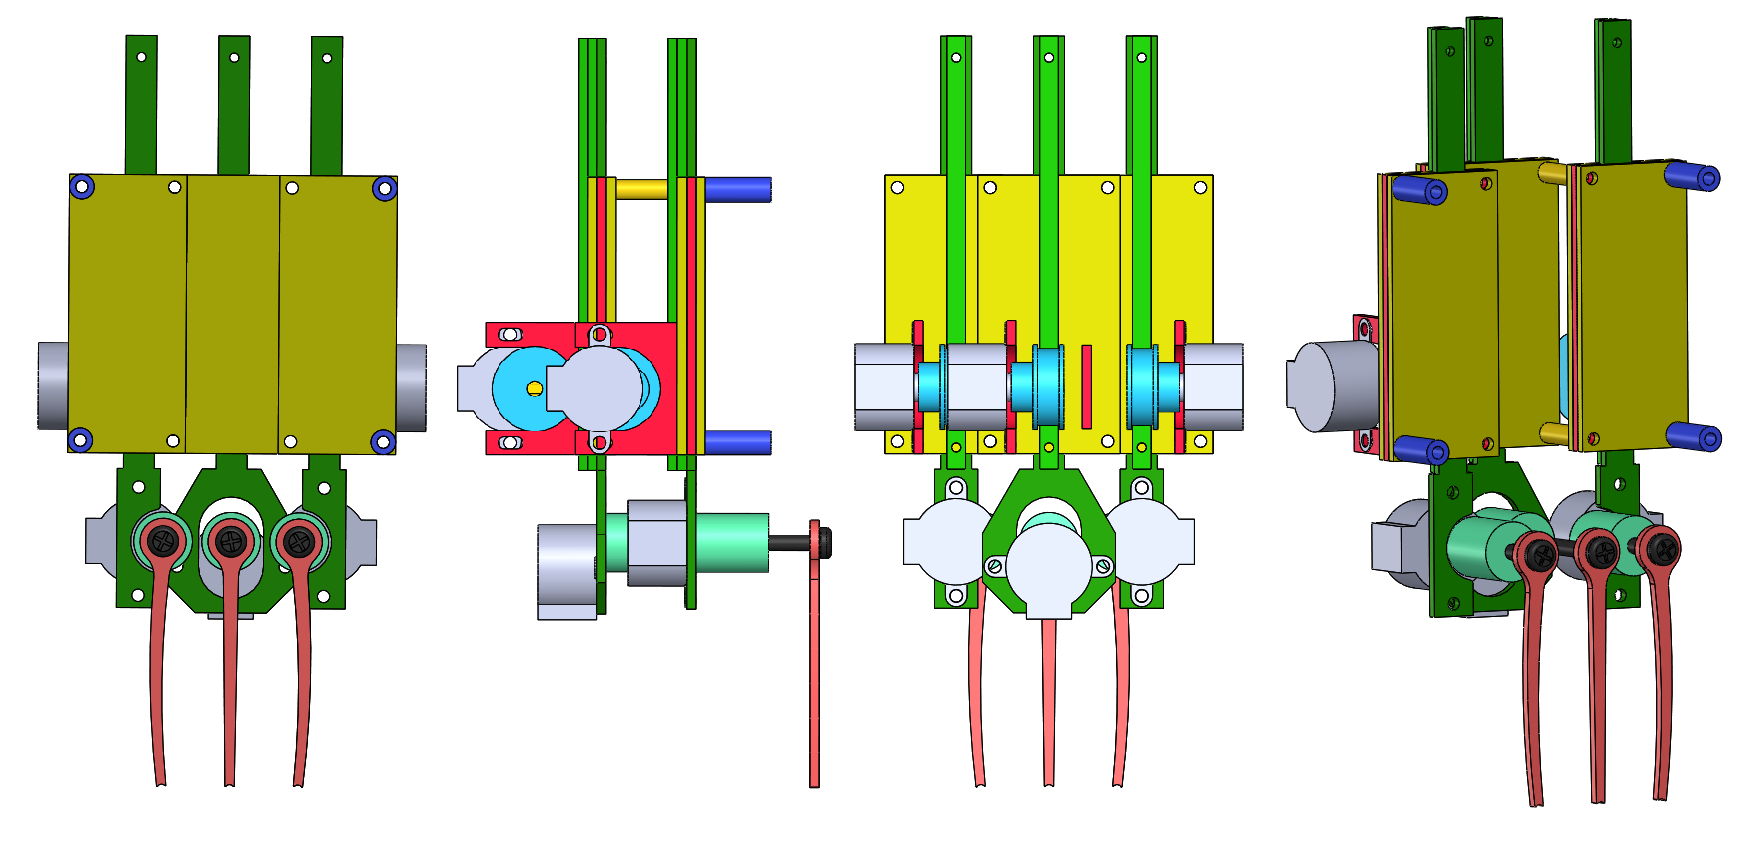

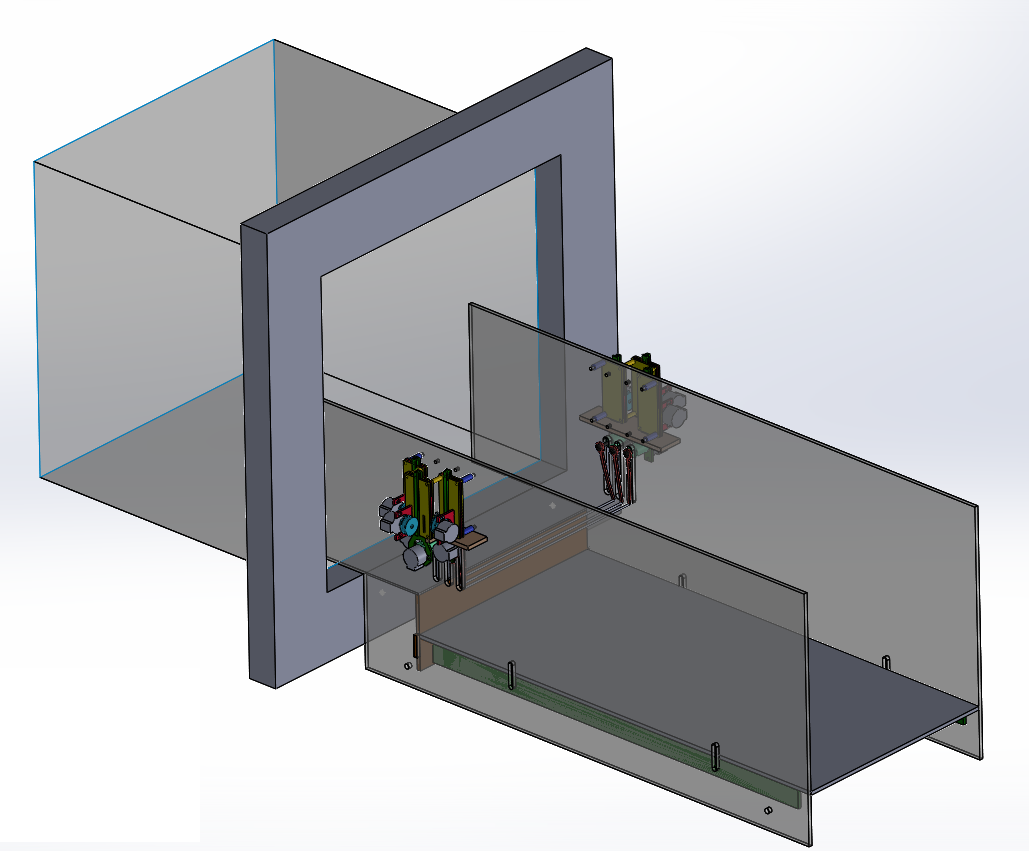

In [3]:
display("image/png", read("figuras/vistas_projMec.png"))
display("image/png", read("figuras/projMec.png"))

The system itself is compact and modular. It can be applied to study one, two or three control cylinders. The arms (bell cranck) ends were designed to allow the cylinders to reach minimum distances from each other.

The alignment can be a challenge. Moreover, special templates need to be designed for the initial referencing. 

## Angular displacements of the stepper motors from an arbitrary position (x,y)

The figure below shows the angular displacement of the stepper motor responsible for the $x$ displacement of a cylinder. Because the displacement is angular, there will be an unwanted $y$ displacement, denoted as $y^*$.

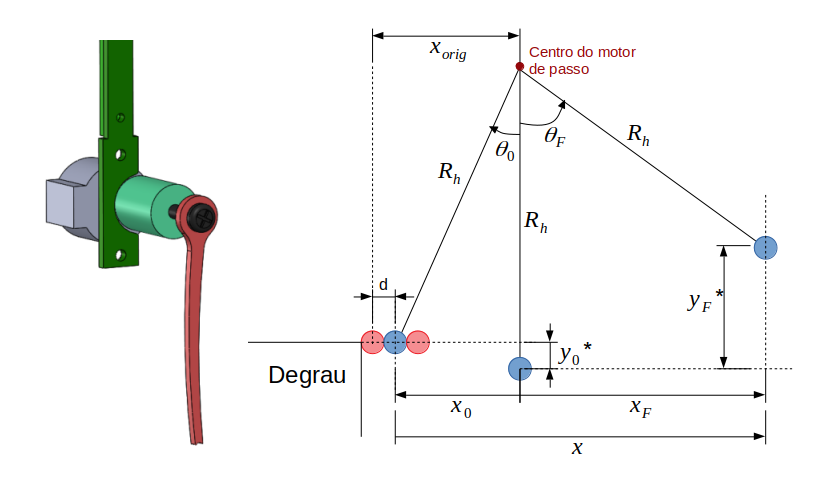

In [5]:
display("image/png", read("figuras/moveX.png"))

It should be noticed that in order to determine the angular displacement needed ($\theta_1$), the initial angular position $\theta_0$ and the final angular positio ($\theta_F$) must be known. **Both positions are computed respect to the vertical line that passes through the stepper motor's center of rotation, considering as positive direction counter clockwise rotations**.


$$ \theta_1 = \theta_F - \theta_0 $$

The $x$ position is also measured from the vertical line that passes through the stepper motor's center. **Movements from left to right are considered to be positive**, so

$$ x = x_F - x_0 $$

Knowing that $R_h$ is the bell cranck length (red element of the 3D figure above), one can calculate the $\theta_1$ value.

$$ \theta_1 = asin\left(\frac{x+x_0}{R_h}\right) - asin\left(\frac{x_0}{R_h}\right) $$

Similarly, the $y^*$ value, which corresponds to a $y$ displacement as an effect of the circular trajectory, can be computed. This value will be used to find the number of steps of the second stepper motor, responsible for the $y$ displacement exclusively.

$$ y^* = y^*_F - y^*_0 $$


$$ y^*_0 = R_h[1-cos(\theta_0)] \quad and \quad y^*_F = R_h[1-cos(\theta_1 + \theta_0)] $$



$$ y^* = R_h[cos(\theta_0) - cos(\theta_1 + \theta_0)] $$

It should be noticed that if the initial position is vertical ($\theta_0 = 0$), any angular displacement produces positive $y^*$, which is positive upwards. The only posibility for negative $y^*$ is for $\theta_0 \neq 0$. 

The way the algorithm was written, the distances from each stepper motor's center of rotation with respect to the center of the first cylinder, positioned on the origin, must be given.

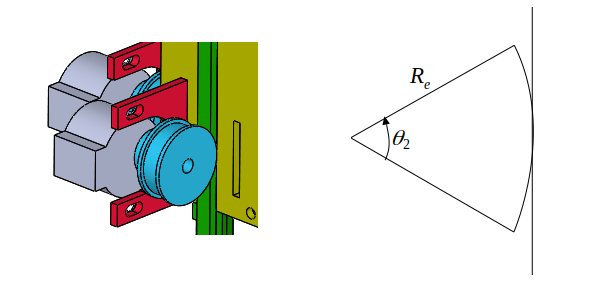

In [6]:
display("image/png", read("figuras/moveY.png"))

A rack and pinion system (Gt2 timing belt with pulley) is responsible for the $y$ displacement exclusively. A stepper motor is used to move the pinion as illustrated above. The angular displacement needed for the pinion ($\theta_2$) can be found from the expression below, $R_e$ beeing the pinion radius (half the primitive diameter).

$$ \theta_2 = \frac{y - y^*}{R_e} $$

Knowing the angular displacements of each stepper motor, the number of steps needed can be found.

Number of steps for the first stepper motor (mainly horizontal displacements) = $\theta_1/k$

Number of steps for the second stepper motor (vertical displacements) = $\theta_2/k$

$k$ = a factor to convert the number of steps to angular displacement (rad).

$spr$ = the value of steps per 360º rotation. For the stepper motors used during the test campaign the value given by the manufaturer is 2048. Calibration migh be necessary.
 

$$ k = \frac{2\pi}{spr} $$

## Controlling the stepper motors with StepperControl.jl package

In the `stepper_move.jl` file functions are given to connect to the system using `StepperControl.jl` package.

The $spr$ values as well as bell cranck length, pinion radius and the distance from the origin to the center of rotation must be modified accordingly.

Check StepperControl.jl documentation!

The connection must be done with `stepper_open` function.

Then the system must be configured to inform the motor IDs, the conversion functions and dependencies.

As an example check out the function `open_onecylinder` inside `stepper_move.jl`

In [7]:
# Function inside stepper_move.jl
function open_onecylinder(sprx=2048, spry=2048; R=80.0, r=12.5, xorig=-41.5, testnocon=false)

    # getting connection
    if testnocon
        dev = stepper_open(2, testnocon=true)
    else
        dev = stepper_open(2)
    end 

    # transformation functions
    s2cx = step2coord_x(sprx=sprx, R=R, xorig=xorig)
    s2cy = step2coord_y(sprx=sprx, spry=spry, R=R, r=r, xorig=xorig)
    c2sx = coord2step_x(sprx=sprx, R=R, xorig=xorig)
    c2sy = coord2step_y(sprx=sprx, spry=spry, R=R, r=r, xorig=xorig)

    stepper_config!(dev, motorID=["x1","y1"], step2coord=[s2cx,s2cy], coord2step=[c2sx,c2sy], depend=[1,[1,2]])

    return dev
end

The movement to a new position can be made with the function `movecyl!`. The arguments for this function are basically the connection and the new position. Absolute movement relative to the origin is preferred. If relative movement is desired one can use `relat=true`. An algorithm to determined the best moving strategy (multiple cylinders scenario) is called.

```julia
# Final position
p = ThreeCylType(15.0,2.0,3.0,1.0,2.5,0.0)

# Move
movecyl!(dev, p)
```